In [1]:
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib widget

# ulaz je u realnom vremenu sa tastature a izlaz string binarnog koda
def GetMessage(mytextstring = ""):
    if not mytextstring:
        mytextstring = input("Unesite poruku: ")

    binarray = ''.join(list(f"{ord(ch):08b}" for ch in mytextstring))

    return binarray


# Pravljenje šifre

In [10]:
bin_code = GetMessage("tekst")
print(bin_code)
print(len(bin_code))

0111010001100101011010110111001101110100
40


# CPMFSK, Barker i parnost

interactive(children=(Text(value='44100', description='fs'), Text(value='10000', description='f0'), Text(value…

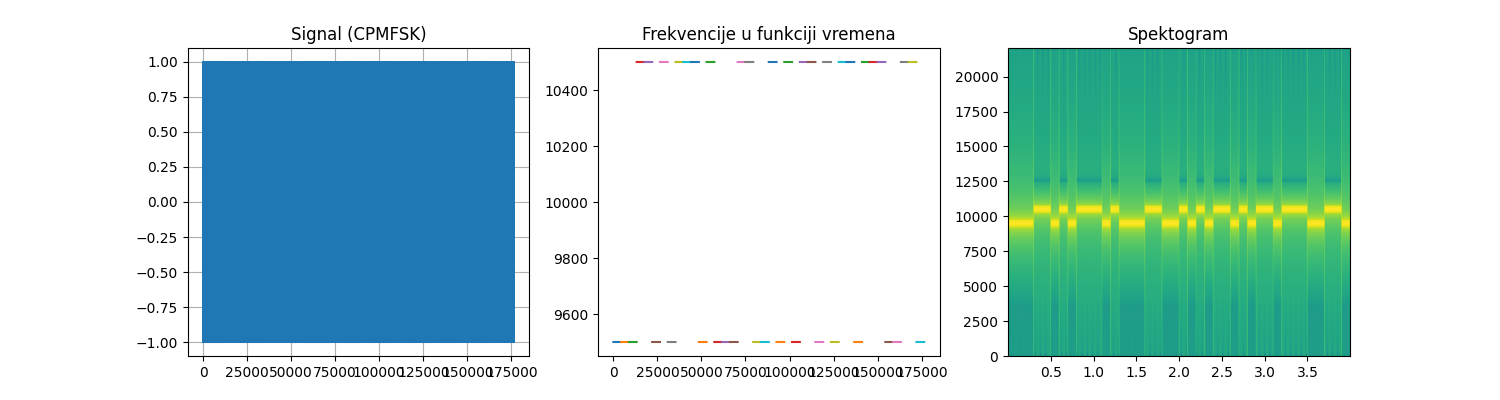

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

mfsk = None
cpmfsk = None
sample_rate = None

@widgets.interact(fs="44100", f0="10000", df = "1000", m="1", dt = "0.1", barker = True, parity = True)
def update(fs = 44100, f0=10000, df=1000, m = 1, dt = "0.1", barker = True, parity = True):

    # čišćenje plota
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    ax[0].grid(True)

    # učitavanje globalnih promenjivih
    global bin_code, mfsk, cpmfsk, sample_rate
    num_bits = len(bin_code)

    # manipulacija sa ulaznim parametrima
    if fs == "": fs = 44100
    if f0 == "": f0 = 10000
    if df == "": df = 1000
    if m == "": m = 1
    if dt == "": dt = .1

    m = int(m)
    f0 = float(f0)
    df = float(df)/2
    fs = int(fs)
    dt = float(dt)

    # Barker
    if barker:
        barker_code = "0001101"
        new_bin_code = barker_code + bin_code
    else:
        new_bin_code = bin_code

    # Parnost - popravljanje binarnog koda poruke ako se šalje po bajt
    if m >= 8 and parity:
        final_bin_code = new_bin_code[:7] if barker else ""
        b = 7 if barker else 0
        for i in range((num_bits - b) // 8):
            pack = new_bin_code[8 * i + b: 8 * i + 8 + b]
            parity = "1" if sum([int(ch) for ch in pack]) % 2 == 1 else "0"
            final_bin_code += pack + parity
    else: final_bin_code = new_bin_code

    # pravljenje paketa koji se šalju
    bin_code_help = [final_bin_code[m * i : m * i + m] for i in range(len(final_bin_code)//m)]
    if num_bits % m != 0: bin_code_help.append(new_bin_code[-(num_bits % m):] + "0" * (m - (num_bits % m)))
    print(bin_code_help)

    # pravljenje frekvencija za pakete
    f = np.linspace(f0 - df, f0 + df, 2 ** m)

    # priprema za pravljenje mfsk niza
    samples_per_symbol = int(int(fs) * dt)
    time = np.linspace(0, int(num_bits * samples_per_symbol // m), int(num_bits * samples_per_symbol // m))
    mfsk = np.zeros(time.shape)
    
    # pravljenje mfsk niza sa frekvencijama
    for j, bits in enumerate(bin_code_help):
        n = int(bits, 2)
        mfsk[j * samples_per_symbol: (j + 1) * samples_per_symbol] = f[n]
        ax[1].plot(time[j*samples_per_symbol: (j + 1) * samples_per_symbol], mfsk[j * samples_per_symbol: (j + 1) * samples_per_symbol])
    
    # pravljenje cpmfsk signala
    delta_phi = mfsk * np.pi / (fs / 2.0)
    phi = np.cumsum(delta_phi)
    cpmfsk = np.sin(phi)

    # plotovanje signala i spektograma
    fig.set_label(" ")
    ax[0].set_title("Signal (CPMFSK)")
    ax[1].set_title("Frekvencije u funkciji vremena")
    ax[2].set_title("Spektogram")
    ax[0].plot(cpmfsk)
    ax[2].specgram(cpmfsk, Fs=fs, scale='dB')

    # postavljanje novih vrednosti globalnih promenljiva
    sample_rate = fs

# Signal with noise

interactive(children=(Text(value='10', description='AS'), Text(value='20', description='SNR'), Output()), _dom…

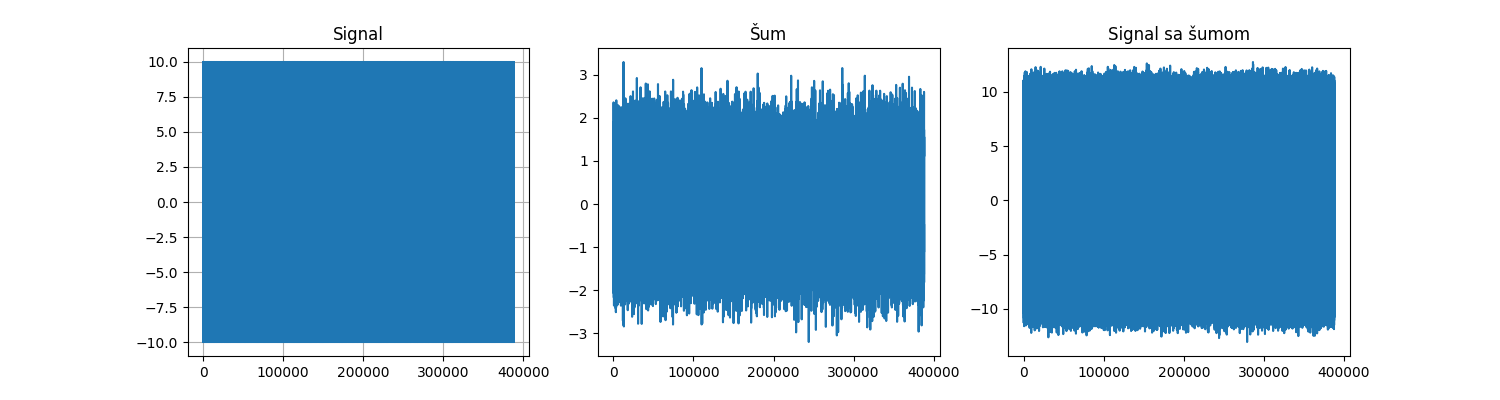

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

after_efect = None
noise = None
signal_with_noise = None

@widgets.interact(AS = "10", SNR = "20")
def update(AS = "10", SNR = "20"):

    # čišćenje plota
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    ax[0].grid(True)

    # učitavanje globalnih promenjivih
    global cpmfsk, after_efect, noise, signal_with_noise

    # manipulacija sa ulaznim parametrima
    if AS == "": AS = 10.
    if SNR == "": SNR = 20.

    AS = float(AS)
    SNR = float(SNR)

    # pojačavanje signala
    after_efect = AS * cpmfsk

    # pravljenje šuma sa određenim SNRom
    snr_db = SNR
    sig_watts = np.mean(after_efect ** 2)
    sig_db = 10 * np.log10(sig_watts)
    noise_db = sig_db - snr_db
    noise_watts = 10 ** (noise_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_watts), len(after_efect))
    
    # spajanje signala i šuma
    signal_with_noise = after_efect + noise

    # plotovanje signala
    fig.set_label(" ")
    ax[0].set_title("Signal")
    ax[1].set_title("Šum")
    ax[2].set_title("Signal sa šumom")
    ax[0].plot(after_efect)
    ax[1].plot(noise)
    ax[2].plot(signal_with_noise)

# Export

In [9]:
import wave

@widgets.interact(noise = False)
def update(noise = False):
    signal = cpmfsk if not noise else signal_with_noise
    audio = (signal * (2 ** 15 - 1)).astype("<h")

    with wave.open("sifra sifra.wav", "w") as f:
        f.setnchannels(1)
        f.setsampwidth(2)
        f.setframerate(sample_rate)
        f.writeframes(audio.tobytes())

interactive(children=(Checkbox(value=False, description='noise'), Output()), _dom_classes=('widget-interact',)…

In [15]:
import zfec
import numpy as np
a = zfec.easyfec.Encoder(7,14)
encoded = a.encode(bytes("fasd",'utf-8'))

In [22]:
print(encoded)

[b'f', b'a', b's', b'd', b'\x00', b'\x00', b'\x00', b'\x8a', b'\xc4', b'\xcd', b'\x8f', b'\xe7', b'\x97', b'\x04']


[0, 1, 2, 3, 4, 5, 6, 7]

In [28]:
decoder  = zfec.easyfec.Decoder(7,14)
decoded = decoder.decode(encoded[:7], list(range(7)), 0)

In [26]:
decoded

b'fasd\x00\x00\x00'